In [13]:
import nltk
from nltk.corpus import semcor
import spacy
from nltk.corpus import wordnet
import string

import polars as pl

import sys
sys.path.append('..')
from utils import utils as u

In [14]:
WORDNET_SUPERSENSES = [
    "act",
    "animal",
    "artifact",
    "attribute",
    "body",
    "cognition",
    "communication",
    "event",
    "feeling",
    "food",
    "group",
    "location",
    "motive",
    "object",
    "person",
    "phenomenon",
    "plant",
    "possession",
    "process",
    "quantity",
    "relation",
    "shape",
    "state",
    "substance",
    "time"
]

WORDNET_SUPERSENSES_SYNSETS = {}

for word in WORDNET_SUPERSENSES:
    WORDNET_SUPERSENSES_SYNSETS[word] = wordnet.synsets(word, 'n')


In [15]:
WORDNET_SUPERSENSES_SYNSETS

{'act': [Synset('act.n.01'),
  Synset('act.n.02'),
  Synset('act.n.03'),
  Synset('act.n.04'),
  Synset('act.n.05')],
 'animal': [Synset('animal.n.01')],
 'artifact': [Synset('artifact.n.01')],
 'attribute': [Synset('property.n.04'), Synset('attribute.n.02')],
 'body': [Synset('body.n.01'),
  Synset('body.n.02'),
  Synset('body.n.03'),
  Synset('body.n.04'),
  Synset('torso.n.01'),
  Synset('body.n.06'),
  Synset('consistency.n.01'),
  Synset('body.n.08'),
  Synset('body.n.09'),
  Synset('soundbox.n.01'),
  Synset('body.n.11')],
 'cognition': [Synset('cognition.n.01')],
 'communication': [Synset('communication.n.01'),
  Synset('communication.n.02'),
  Synset('communication.n.03')],
 'event': [Synset('event.n.01'),
  Synset('event.n.02'),
  Synset('event.n.03'),
  Synset('consequence.n.01')],
 'feeling': [Synset('feeling.n.01'),
  Synset('impression.n.01'),
  Synset('spirit.n.02'),
  Synset('feeling.n.04'),
  Synset('touch.n.10'),
  Synset('feeling.n.06')],
 'food': [Synset('food.n.01')

In [16]:
#scelgo il verbo 
verb = 'love'

In [17]:
# recupero da un corpus tutte le frasi che lo contengono

nlp = spacy.load("en_core_web_sm")

sentences = semcor.sents()

# Converte le liste di token in stringhe
corpus = []
for sentence in sentences:
    
    str_sent = ""
    for token in sentence:
       
        if token.startswith(tuple(string.punctuation)):
            str_sent += token
        else:
            str_sent += ' '+token
    str_sent = str_sent.replace("''", "")
    str_sent = str_sent.replace("``", "")

    doc = nlp(str_sent)
    if any(token.lemma_ == verb for token in doc):
        corpus.append(str_sent)

print(len(corpus))


184


In [18]:
semantic_roles = {}
i = 1
for sentence in corpus:
    doc = nlp(sentence)
    # Estrai ruoli sintattici e tipi semantici
    obj_synset = []
    subj_synset = []
    for token in doc:

        if token.dep_ == "nsubj":
            word = u.lemmatize_word(token.text, 'n')
            subj_synset = wordnet.synsets(word, 'n')
        if token.dep_ == "dobj":
            word = u.lemmatize_word(token.text, 'n')
            obj_synset = wordnet.synsets(word, 'n')

        if len(obj_synset) > 0 and len(subj_synset) > 0:
            # Mappatura a tipi semantici utilizzando WordNet (solo come esempio)
            semantic_roles[i] = {}
            semantic_roles[i]['nsubj'] = subj_synset
            semantic_roles[i]['dobj'] = obj_synset
    i += 1


In [19]:
def get_supersenses(sense):
    senses = [sense]

    while senses:
        current_synset = senses.pop(0)

        for word in WORDNET_SUPERSENSES_SYNSETS:

            if current_synset in WORDNET_SUPERSENSES_SYNSETS[word]:
                return word

        hypernyms = current_synset.hypernyms()
        senses.extend(hypernyms)
    return None


In [46]:
def get_best_supersenses(sense):
    senses = [sense]
    supersenses_list = {}

    while senses:
        #print(senses)
        current_synset = senses.pop(0)

        for word in WORDNET_SUPERSENSES_SYNSETS:

            if current_synset in WORDNET_SUPERSENSES_SYNSETS[word]:
                if word not in supersenses_list:
                    supersenses_list[word] = 1
                else:
                    supersenses_list[word] += 1

        hypernyms = current_synset.hypernyms()
    
        senses.extend(hypernyms)
    if len(supersenses_list) > 0:
        return next(iter(supersenses_list))
    else:
        return None




phenomenon


In [47]:
#per ogni coppia sogetto, oggetto vado a prendere i supersense

supersenses_subj_obj = {}

# this version if you need count in each index
#
# for index in semantic_roles:
#     supersenses_subj_obj[index] = {}
#     if 'nsubj' in semantic_roles[index].keys() and 'dobj' in semantic_roles[index].keys():
#         for synset_subj in semantic_roles[index]['nsubj']:
#             supersenses_subj = get_supersenses(synset_subj)
#             for synset_obj in semantic_roles[index]['dobj']: 
#                 supersenses_obj = get_supersenses(synset_obj)
#                 if (supersenses_subj, supersenses_obj) not in supersenses_subj_obj[index]:
#                     supersenses_subj_obj[index][(supersenses_subj, supersenses_obj)] = 1
#                 else:
#                     supersenses_subj_obj[index][(supersenses_subj, supersenses_obj)] += 1


for index in semantic_roles:
    supersenses_subj_obj[index] = []
    if 'nsubj' in semantic_roles[index].keys() and 'dobj' in semantic_roles[index].keys():
        for synset_subj in semantic_roles[index]['nsubj']:
            supersenses_subj = get_best_supersenses(synset_subj)
            for synset_obj in semantic_roles[index]['dobj']: 
                supersenses_obj = get_best_supersenses(synset_obj)
                if supersenses_subj is not None and supersenses_obj is not None:
                    supersenses_subj_obj[index].append((supersenses_subj, supersenses_obj))
    supersenses_subj_obj[index] = list(set(supersenses_subj_obj[index]))



In [48]:
semantic_patterns = {}
for index in supersenses_subj_obj:
    for couple in supersenses_subj_obj[index]:
            if couple not in semantic_patterns:
                semantic_patterns[couple] = [index]
            else:
                semantic_patterns[couple] += [index]


In [49]:
len(supersenses_subj_obj)

89

In [50]:
semantic_patterns = dict(
    sorted(semantic_patterns.items(), key=lambda item: len(item[1]), reverse=True))

for key in semantic_patterns:
    print(key, semantic_patterns[key])

tab = pl.DataFrame()



('communication', 'attribute') [11, 46, 63, 67, 70, 82, 83, 85, 156, 162]
('substance', 'attribute') [11, 46, 63, 67, 70, 82, 83, 85, 156, 162]
('substance', 'act') [3, 12, 13, 21, 70, 85, 154, 156, 162]
('communication', 'act') [3, 12, 13, 21, 70, 85, 154, 156, 162]
('substance', 'state') [12, 13, 19, 29, 63, 70, 154, 162]
('communication', 'person') [21, 30, 33, 77, 123, 124, 156, 180]
('substance', 'person') [21, 30, 33, 77, 123, 124, 156, 180]
('communication', 'state') [12, 13, 29, 63, 70, 154, 162]
('communication', 'cognition') [23, 42, 53, 63, 64, 70, 106]
('person', 'cognition') [57, 92, 106, 144, 147, 161, 165]
('act', 'act') [2, 12, 13, 72, 98, 149]
('group', 'person') [56, 79, 105, 122, 129, 141]
('cognition', 'cognition') [69, 102, 106, 118, 133, 144]
('group', 'cognition') [23, 125, 129, 141, 165]
('group', 'artifact') [24, 56, 65, 93, 129]
('communication', 'group') [29, 82, 83, 162, 170]
('substance', 'group') [29, 82, 83, 162, 170]
('substance', 'quantity') [33, 42, 77

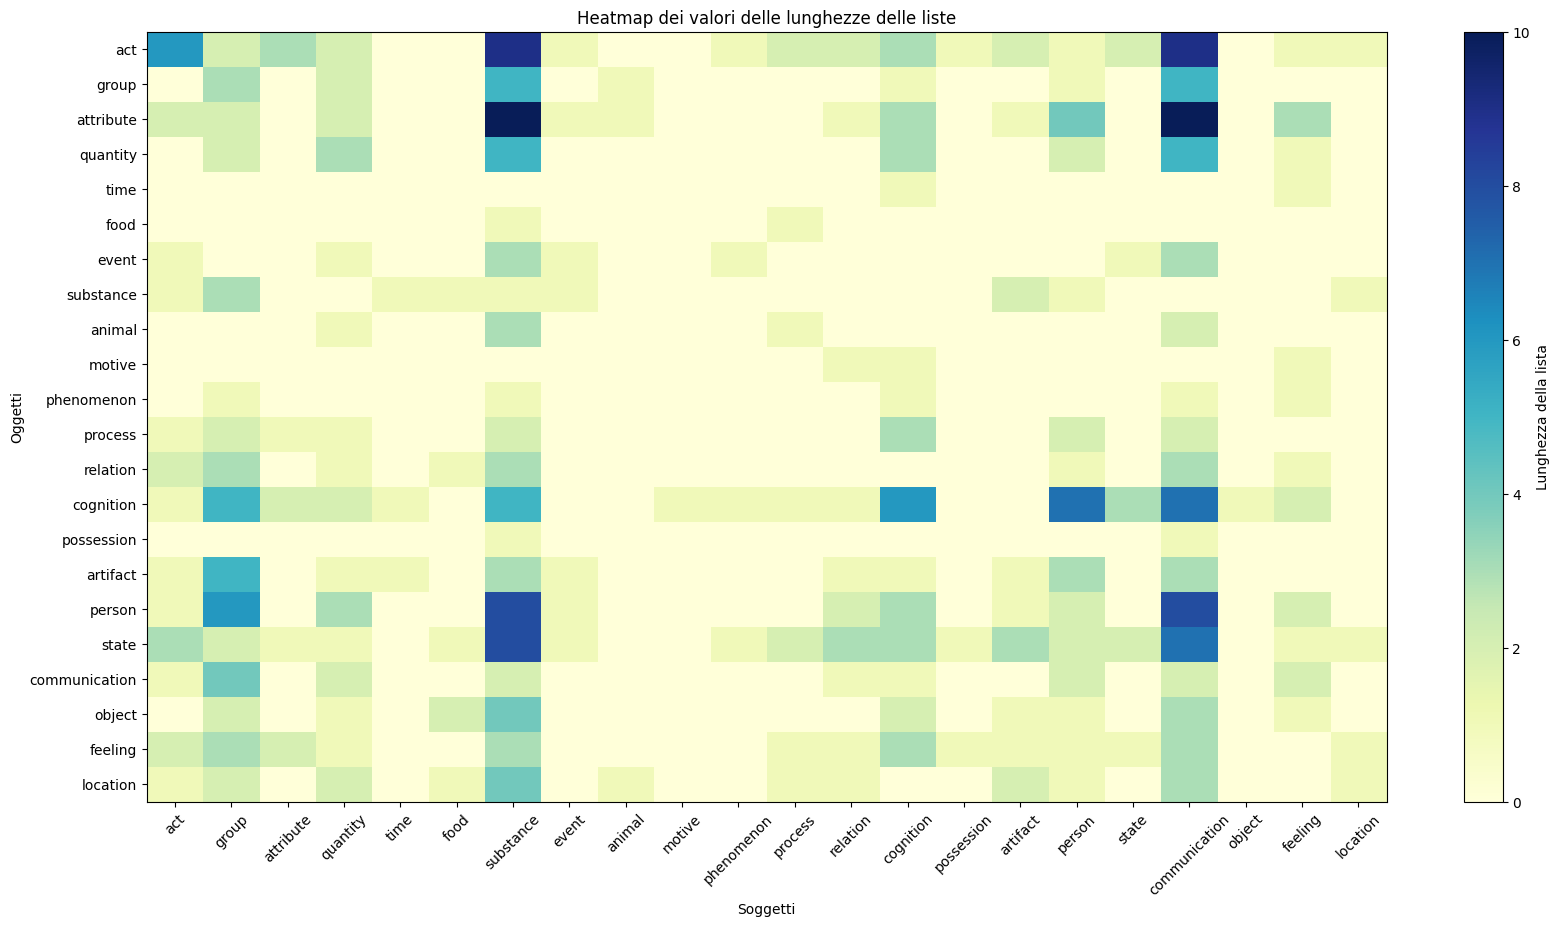

In [51]:
import pandas as pd

# I tuoi dati
dati = []

for key in semantic_patterns:
    dati.append(((key[0], key[1]), semantic_patterns[key]))

# Estrai l'elenco completo di primi e secondi elementi
primi_elementi = list(set([coppia[0] for coppia, _ in dati]))
secondi_elementi = list(set([coppia[1] for coppia, _ in dati]))

# Creazione del DataFrame
df = pd.DataFrame(columns=primi_elementi, index=secondi_elementi)

# Riempi il DataFrame con i valori delle lunghezze delle liste
for coppia, lista in dati:
    primi_elem = coppia[0]
    secondo_elem = coppia[1]
    valore = len(lista)
    df.loc[secondo_elem, primi_elem] = valore

# Visualizzazione del DataFrame
import matplotlib.pyplot as plt

# ... (Codice per creare il DataFrame)


df = df.fillna(0)
# Esempio 1: Heatmap
plt.figure(figsize=(20, 10))
plt.title('Heatmap dei valori delle lunghezze delle liste')
plt.xlabel('Soggetti')
plt.ylabel('Oggetti')
plt.imshow(df, cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Lunghezza della lista')
plt.xticks(ticks=range(len(primi_elementi)), labels=primi_elementi, rotation=45)
plt.yticks(ticks=range(len(secondi_elementi)), labels=secondi_elementi)
plt.show()
